In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import time

print('Done')

Done


In [17]:
past_traj = torch.load('my_data/past.pt', map_location=torch.device('cpu'))
fut_traj = torch.load('my_data/future.pt', map_location=torch.device('cpu'))

traj = torch.cat((past_traj, fut_traj), dim=2) * 94 / 28

prediction = torch.load('my_data/prediction.pt', map_location=torch.device('cpu'))
prediction = (prediction * 5 + past_traj[:, :, -1:].contiguous().view(-1, 1, 2)[:, None]) * 94 / 28

goal = torch.load('my_data/goal.pt', map_location=torch.device('cpu'))
goal = (goal * 5 + past_traj[:, :, -1:].contiguous().view(-1, 1, 2)[:, None]) * 94 / 28


mean = torch.load('my_data/p_mean_denoise.pt', map_location=torch.device('cpu'))[:, 0]
mean = (mean * 5 + past_traj[:, :, -1:].contiguous().view(-1, 1, 2)) * 94 / 28

sigma = torch.load('my_data/p_sigma.pt', map_location=torch.device('cpu'))
sigma = torch.exp(sigma/2)

intention = torch.load('my_data/p_intention.pt', map_location=torch.device('cpu'))
similarity = torch.load('my_data/p_similarity.pt', map_location=torch.device('cpu'))

print('Done')

Done


In [18]:
court = plt.imread("court.png")
mask = np.zeros_like(court)

class Constant:
    """A class for handling constants"""
    NORMALIZATION_COEF = 7
    PLAYER_CIRCLE_SIZE = 12 / NORMALIZATION_COEF
    INTERVAL = 10
    DIFF = 6
    X_MIN = 0
    X_MAX = 100
    Y_MIN = 0
    Y_MAX = 50
    COL_WIDTH = 0.3
    SCALE = 1.65
    FONTSIZE = 6
    X_CENTER = X_MAX / 2 - DIFF / 1.5 + 0.10
    Y_CENTER = Y_MAX - DIFF / 1.5 - 0.35

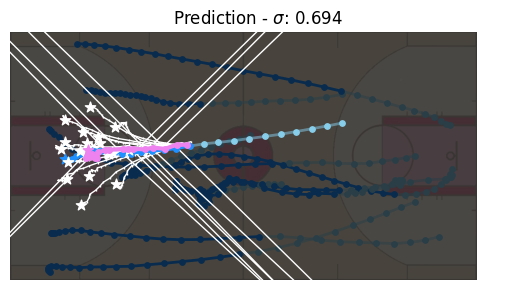

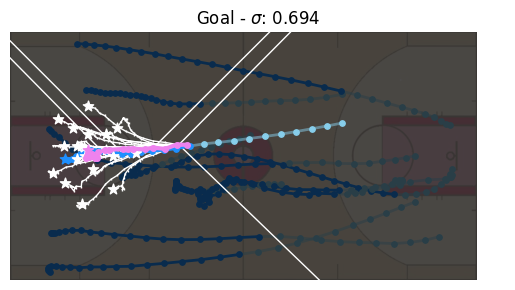

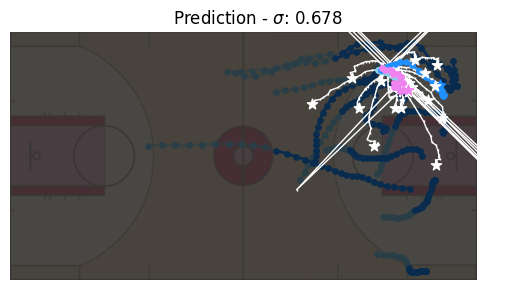

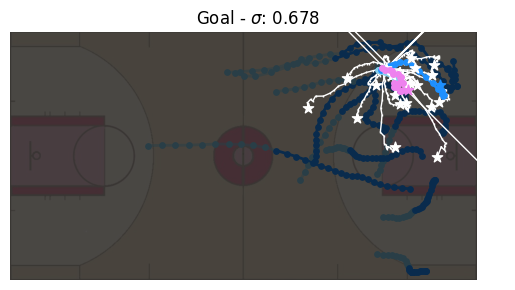

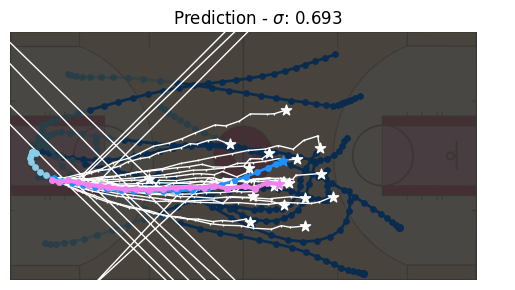

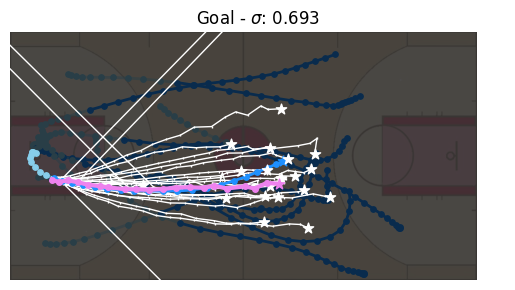

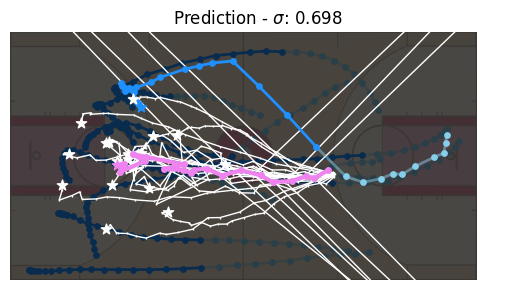

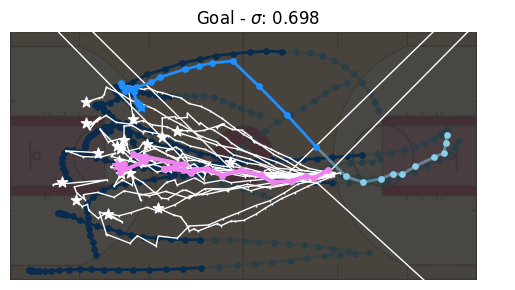

In [23]:
idx = [[0, 0], [2, 8], [3, 0], [4, 10]]

for i in idx:
    scene = i[0]
    actor_num = i[1]

    for plot_type in ["prediction", "goal"]:  # 区分 prediction 和 goal 图
        plt.clf()

        ax = plt.axes(xlim=(Constant.X_MIN,
                            Constant.X_MAX),
                    ylim=(Constant.Y_MIN,
                            Constant.Y_MAX))
        ax.axis('off')
        fig = plt.gcf()
        ax.grid(False)  # Remove grid

        idx = scene * 11 + actor_num

        colorteam1 = 'dodgerblue'
        colorteam2 = 'dodgerblue'
        colorball = 'dodgerblue'
        colorteam1_pre = 'skyblue'
        colorteam2_pre = 'skyblue'
        colorball_pre = 'skyblue'

        traj_curr = traj[scene, actor_num].numpy()
        traj_data = prediction[idx] if plot_type == "prediction" else goal[idx]  # 根据类型选择数据
        traj_mean_data = mean[idx]

        # 背景球员
        for actor_num_other in range(11):
            zorder = 5
            if actor_num_other == actor_num:
                zorder = 105
            traj_curr_ = traj[scene, actor_num_other].numpy()
            if actor_num_other < 5:
                color = colorteam1
                color_pre = colorteam1_pre
            elif actor_num_other < 10:
                color = colorteam2
                color_pre = colorteam2_pre
            else:
                color_pre = colorball_pre
                color = colorball
            for i in range(30):
                points = [(traj_curr_[i, 0], traj_curr_[i, 1])]
                (x, y) = zip(*points)
                if i < 10:
                    plt.scatter(x, y, color=color_pre, s=15, alpha=1, zorder=zorder)
                else:
                    if actor_num_other == actor_num and i == 29:
                        plt.scatter(x, y, color=color, s=60, marker='*', alpha=1, zorder=zorder)

                    plt.scatter(x, y, color=color, s=15, alpha=1, zorder=zorder)

            for i in range(29):
                points = [(traj_curr_[i, 0], traj_curr_[i, 1]), (traj_curr_[i + 1, 0], traj_curr_[i + 1, 1])]
                (x, y) = zip(*points)
                if i < 10:
                    plt.plot(x, y, color=color_pre, alpha=0.5, linewidth=2, zorder=zorder - 1)
                else:
                    plt.plot(x, y, color=color, alpha=1, linewidth=2, zorder=zorder - 1)

        # 目标轨迹或预测轨迹
        for i in range(20):
            plt.plot(traj_data[i, :19, 0], traj_data[i, :19, 1], 
                     linestyle='-', markersize=2, marker="|", alpha=1,
                     color='white', linewidth=1, zorder=101)
            plt.plot(traj_data[i, 18:, 0], traj_data[i, 18:, 1], 
                     linestyle='-', markersize=0, marker="o", alpha=1,
                     color='white', linewidth=1, zorder=101)

        plt.scatter(traj_data[:, -1, 0], traj_data[:, -1, 1], 
                    marker='*', 
                    color='white', s=60, alpha=1, zorder=120)

        # 平均轨迹
        plt.plot(traj_mean_data[:19, 0], traj_mean_data[:19, 1],
                 linestyle='-', markersize=4, marker="o", alpha=1,
                 color='violet', linewidth=3, zorder=130)
        plt.plot(traj_mean_data[18:, 0], traj_mean_data[18:, 1],
                 linestyle='-', markersize=0, marker="o", alpha=1,
                 color='violet', linewidth=3, zorder=130) 
        plt.scatter(traj_mean_data[-1, 0], traj_mean_data[-1, 1], 
                    marker='*', 
                    color='violet', s=60, alpha=1, zorder=130)

        plt.title(f"{plot_type.capitalize()} - $\sigma$: {sigma[idx, 0]:.3f}")

        plt.imshow(court, zorder=0, extent=[Constant.X_MIN, Constant.X_MAX - Constant.DIFF,
                                            Constant.Y_MAX, Constant.Y_MIN], alpha=0.5)
        plt.imshow(mask, zorder=90, extent=[Constant.X_MIN, Constant.X_MAX - Constant.DIFF,
                                            Constant.Y_MAX, Constant.Y_MIN], alpha=0.7)

        # 保存或展示图像
        # plt.savefig(f'fig3/scene_{scene}_agent_{actor_num}_{plot_type}.jpg', bbox_inches='tight', dpi=300)
        plt.show()
        plt.close()
